The aim of this project is to investigate investors' risk tolerance and their personal perception of it. Next, we will create a model that suggests the ratio of risky to safe assets so that the investor can withstand the determined allocation of assets when the risk materializes.

Data for this project comes from Survey of Consumer Finances 2007 - 2009:<br>https://www.federalreserve.gov/econres/scf_2009p.htm
<br>
Codebook:<br>https://www.federalreserve.gov/econres/files/codebk2009p.txt
<br>
The choice is not accidental, as we want to investigate how the financial crisis of 2008 influenced the financial decisions of the respondents. The idea for the data preparation comes from "Machine Learning and Data Science Blueprints for finance" by Hariom Tatsat, Sahil Puri and Brad Lookabaugh.

In [118]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [119]:
# data load time ~ 3 min
df = pd.read_excel('SCFP2009panel.xlsx')

In [120]:
df.head()

,YY1,Y1,WGT09,AGE07,AGECL07,EDUC07,EDCL07,MARRIED07,KIDS07,LIFECL07,...,NHMORTPCT,WAGEINCPCT,BUSSEFARMINCPCT,INTDIVINCPCT,KGINCPCT,SSRETINCPCT,TRANSFOTHINCPCT,PSAVINGPCT,LEVERAGEPCT,I
0,1,11,11668.134198,47,3,12,2,1,0,2,...,-21.052632,-32.931828,0.0,15939.278937,0.0,0.0,0.0,93.125197,270.403054,57
1,1,12,11823.456494,47,3,12,2,1,0,2,...,-21.052632,-32.931828,0.0,15939.278937,0.0,0.0,0.0,93.125197,249.593620,57
2,1,13,11913.228354,47,3,12,2,1,0,2,...,-50.000000,-32.931828,0.0,15939.278937,0.0,0.0,0.0,93.125197,209.233358,57
3,1,14,11929.394266,47,3,12,2,1,0,2,...,-33.333333,-32.931828,0.0,15939.278937,0.0,0.0,0.0,93.125197,209.273158,57
4,1,15,11917.722907,47,3,12,2,1,0,2,...,-38.596491,-32.931828,0.0,15939.278937,0.0,0.0,0.0,93.125197,232.690767,57


In [121]:
df.shape

(19285, 515)

Our task is to summarize all risky and safe assets in the portfolios of the respondents. Then a comparison of the obtained ratios for 2007 and 2009.

In [122]:
# Risky assets = mutual funds + stocks + corporate bonds
df['Risky2007'] = df['NMMF07'] + df['STOCKS07'] + df['BOND07']
df['Risky2009'] = df['NMMF09'] + df['STOCKS09'] + df['BOND09']

# Safe assets = checking and saving accounts + certificates of deposit + gov bonds + cash
df['Safe2007'] = df['LIQ07'] + df['CDS07'] + df['SAVBND07'] + df['CASHLI07']
df['Safe2009'] = df['LIQ09'] + df['CDS09'] + df['SAVBND09'] + df['CASHLI09']

In [123]:
# Calculating risk tolerance.
df['RiskTol2007'] = df['Risky2007'] / (df['Risky2007'] + df['Safe2007'])
df['RiskTol2009'] = df['Risky2009'] / (df['Risky2009'] + df['Safe2009'])

In [124]:
df.shape

(19285, 521)

In [125]:
# A different approach than the suggestion from the book. We will measure nominal percent change, 
# not a relative change.
df['RiskTolChange'] = df['RiskTol2009'] - df['RiskTol2007']

In [126]:
df=df.dropna()
#df=df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
df.isna().sum().sum()

0

Let's remove people who were not interested or could not invest in 2007. Of course, we'll also accidentally remove people whose true risk tolerance is zero, but that's not a problem.

In [127]:
df=df[df['Risky2007']>0]

In [128]:
df.shape

(7956, 522)

Let's use the following reasonably selected columns as features for our model. <br>
AGE07<br>
Age of person in 2007. <br>
EDCL07<br>
1 = no high school, 4 = college degree.<br>
MARRIED07<br>
1 = married
2 = unmarried.<br>
OCCAT107<br>
Occupation. 1 = managerial status, 4 = unemployed.<br>
KIDS07<br>
Number of children.<br>
WSAVED07<br>
Spending vs income ratio. 1 spending > income, 2 spening ~ income, 3 spendng < income<br>
NETWORTH07<br>
Net worth of respondent.<br>
INCOME07<br>
Income of respondent<br>
RISK07<br>
Level of willingness to take risk. 1 = highest , 4 = lowest.<br>
HHOUSES07<br>
1 = own a home, 0 = does not own a home.<br>
SPENDMOR07<br>
How willing the respondent is to spend more if the assets have appreciated. 1 = is not willing at all, 5 = is willing very much.

In [129]:
keep_columns = ['AGE07','EDCL07','MARRIED07','HHOUSES07','KIDS07','OCCAT107','WSAVED07','INCOME07','SPENDMOR07','RISK07','NETWORTH07',
                'Risky2007','Risky2009','Safe2007','Safe2009','RiskTol2007','RiskTol2009','RiskTolChange']
drop_columns = [column for column in df.columns if column not in keep_columns]

In [130]:
df.drop(labels=drop_columns, axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [131]:
df.shape

(7956, 18)

In [132]:
# copy of dataset for faster loading in the future
df.to_csv('data.csv')

#Exploratory data analysis

In [ ]:
df = pd.read_csv('data.csv')

In [133]:
df['RiskTolChange'].mean()

-0.1385569940011197

In [134]:
df['RiskTol2007'].mean()

0.629715497620536

In [135]:
df['RiskTol2009'].mean()

0.49115850361941243

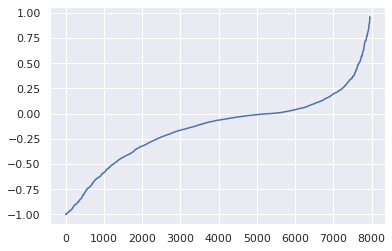

In [136]:
df.sort_values('RiskTolChange').reset_index()['RiskTolChange'].plot()

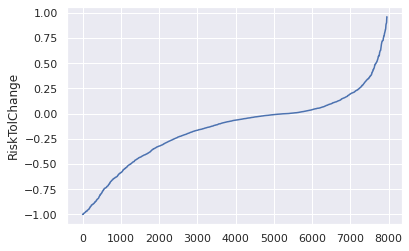

In [137]:
sns.set_theme()
sns.lineplot(data=df.sort_values('RiskTolChange').reset_index()['RiskTolChange'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


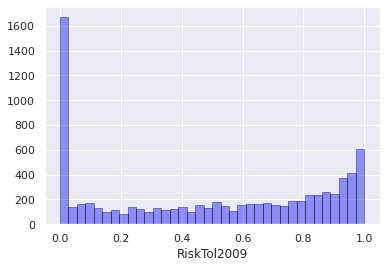

In [138]:
sns.distplot(df['RiskTol2009'], hist=True, kde=False,
 bins=int(180/5), color = 'blue',
 hist_kws={'edgecolor':'black'})